## Rain EDA Notebook
### Dylan M Jones
### 2/11/2021

This notebook is to examine the structure of a weather dataset from kaggle. It contains the weather data from various stations in Australia, with the objective of building a model to predict precipitation the following day.

This dataset looks fun, because we can start with initial assumptions and check whether they hold true with exploration of the variables. It also lays a foundation for possibly asking new questions using the data, or including new external data to the set as we dive deeper and which to enhance the performance of the model.

## Table of Contents

1. [Inspiration](#1)
1. [Data exploration](#2)
    -  [Univariate Analysis](#2.1)
    -  [Bivariate Analysis](#2.2)
    -  [Multivariate Analysis](#2.3)
1. [Feature Engineering](#3)
    -   [Numerical Feature Engineering](#3.1)
    -   [Categorical Feature Engineering](#3.2)
1. [Model Training and Output](#4)
1. [Model Performance Assessment](#5)
    -   [Accuracy vs Recall vs Sensitivity](#5.1)
    -   [Confusion Matrix](#5.2)
    -   [ROC Curve and AUC](#5.3)
1. [Enhancing the Dataset with Geocoding](#6)
    -   [Geocoding Locations](#6.1)
    -   [Gathering topology](#6.2)
    -   [New feature analysis](#6.3)
    -   [New model training](#6.4)
1. [Conclusions](#7)

## 1. Inspiration <a class="anchor" id = "1"></a>

In [63]:
## Initial library setup

import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split 
%matplotlib inline


## Load data
rawWeather = pd.read_csv("weatherAUS.csv")


In [64]:
## Check table
rawWeather['Date'] = pd.to_datetime(rawWeather['Date'])
rawWeather['Month'] = rawWeather['Date'].dt.month
rawWeather['Day'] = rawWeather['Date'].dt.day
rawWeather['Year'] = rawWeather['Date'].dt.year
rawWeather['Weekday'] = rawWeather['Date'].dt.strftime('%A')
rawWeather.drop(['Date'], axis = 1, inplace = True)


print("Dataset dimensions: " + str(rawWeather.shape) + "\n")
print("Dataset variables: " + str(rawWeather.columns))

# print(rawWeather.info())

Dataset dimensions: (145460, 26)

Dataset variables: Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Month', 'Day', 'Year',
       'Weekday'],
      dtype='object')


This looks promising. We can see that there are 145,460 rows, and 22 columns ( + 4 date columns). 25 columns are fields we can use to try and predict the last column ('RainTomorrow').

Let's check how the target variable looks.


In [65]:
print(rawWeather['RainTomorrow'].value_counts())


print("\nRain occurs " + str(round(len(rawWeather[rawWeather['RainTomorrow'] == 'Yes'])/len(rawWeather),4)*100) + " percent of the time\n")



No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

Rain occurs 21.91 percent of the time



I see a categorical output of "Yes" for rain, and "No" for no rain. So far, so good. We should check for missing values before proceeding.

In [66]:
print("Target variable missing from "+ str(rawWeather['RainTomorrow'].isnull().sum()) +" rows")

Target variable missing from 3267 rows


Uh oh. There are a few cases where the target variable is not present. Since the purpose of the model is to predict rain, and the missing variables don't appear to incidate some hidden category, we are going to drop these cases from the the training and test sets before moving forward.

In [67]:
rawWeather.dropna(subset = ['RainTomorrow'], axis = 0, inplace = True)

print("\nNew dimensions: "+ str(rawWeather.shape)  + "\n")


New dimensions: (142193, 26)



Before we move much further in the EDA, we should split the dataset to ensure an unbiased validation process

In [68]:
X_train, X_test, y_train, y_test = train_test_split(rawWeather.loc[:,rawWeather.columns != 'RainTomorrow'],rawWeather.loc[:,'RainTomorrow'], test_size = 0.3, random_state = 42)

print('X_train is: ' + str(X_train.shape))
print('y_train is: ' + str(y_train.shape))
print('X_test is: ' + str(X_test.shape))
print('y_test is: ' + str(y_test.shape))

df_train = pd.concat([X_train, y_train], axis = 1)

X_train is: (99535, 25)
y_train is: (99535,)
X_test is: (42658, 25)
y_test is: (42658,)


In [69]:
print("Training set dimensions: \n" + str(df_train.shape)+ "\n")
print("Data types:\n"+ str(df_train.dtypes)+ "\n")

Training set dimensions: 
(99535, 26)

Data types:
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
Month              int64
Day                int64
Year               int64
Weekday           object
RainTomorrow      object
dtype: object

Category variables: 
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Weekday', 'RainTomorrow']

Numerical variables: 
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pr

It looks like the dataset is part categorical variables, part numerical variables. We will use decision trees as the basis of our models, so both types are accepted. However, these features are treated differently for data cleaning and feature engineering purposes, so we will separate them now.

In [71]:
categorical = [var for var in df_train.columns if df_train[var].dtype == 'O']
numerical = [var for var in df_train.columns if df_train[var].dtype != 'O']
print("Categorical variables: \n" + str(categorical) + "\n")
print("Numerical variables: \n" + str(numerical) + "\n")

Categorical variables: 
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Weekday', 'RainTomorrow']

Numerical variables: 
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Month', 'Day', 'Year']



## 2. Data Exploration<a class="anchor" id = "2"></a>

### 2.1. Univariate analysis <a class="anchor" id = "2.1"></a>

Let's look at some of the numerical variable disributions, to see what we are dealing with

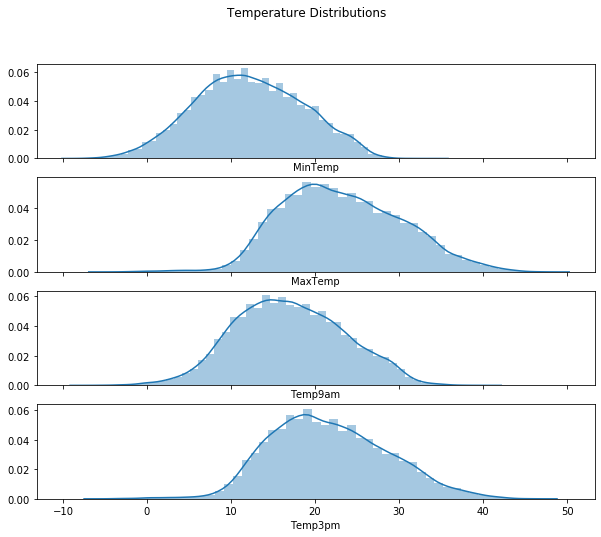

In [89]:



fig, axes = plt.subplots(4, 1, sharex = True, figsize = (10,8))
fig.suptitle("Temperature Distributions")
fig = sns.distplot(df_train['MinTemp'], ax = axes[0])
fig = sns.distplot(df_train['MaxTemp'], ax = axes[1])
fig = sns.distplot(df_train['Temp9am'], ax = axes[2])
fig = sns.distplot(df_train['Temp3pm'], ax = axes[3])
plt.show()

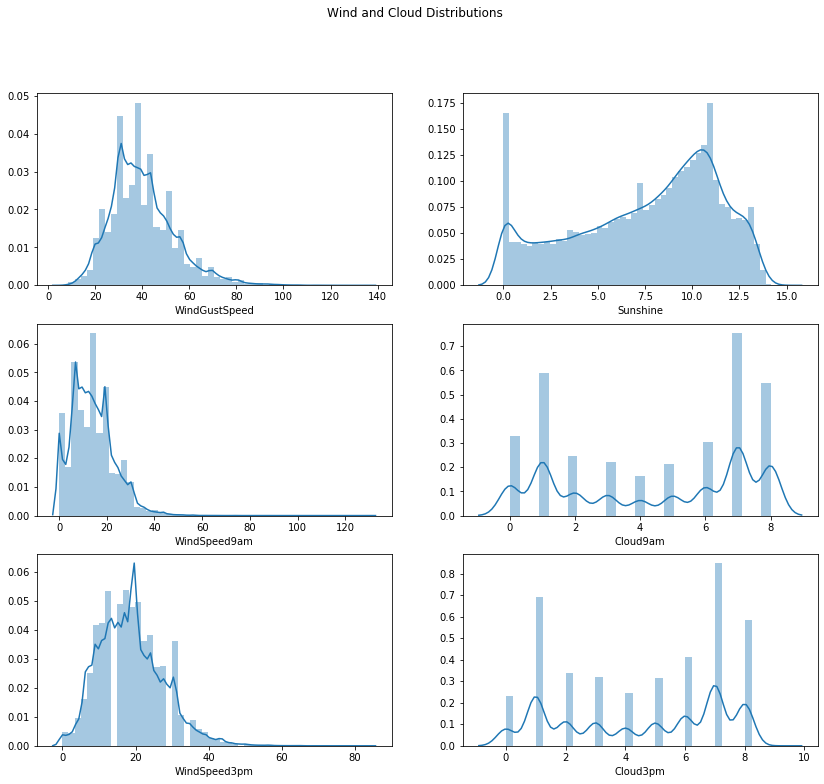

In [97]:
fig, axes = plt.subplots(3, 2, sharex = False, figsize = (14,12))
fig.suptitle("Wind and Cloud Distributions")
fig = sns.distplot(df_train['WindGustSpeed'], ax = axes[0,0])
fig = sns.distplot(df_train['WindSpeed9am'], ax = axes[1,0])
fig = sns.distplot(df_train['WindSpeed3pm'], ax = axes[2,0])
fig = sns.distplot(df_train['Sunshine'], ax = axes[0,1])
fig = sns.distplot(df_train['Cloud9am'], ax = axes[1,1])
fig = sns.distplot(df_train['Cloud3pm'], ax = axes[2,1])
plt.show()

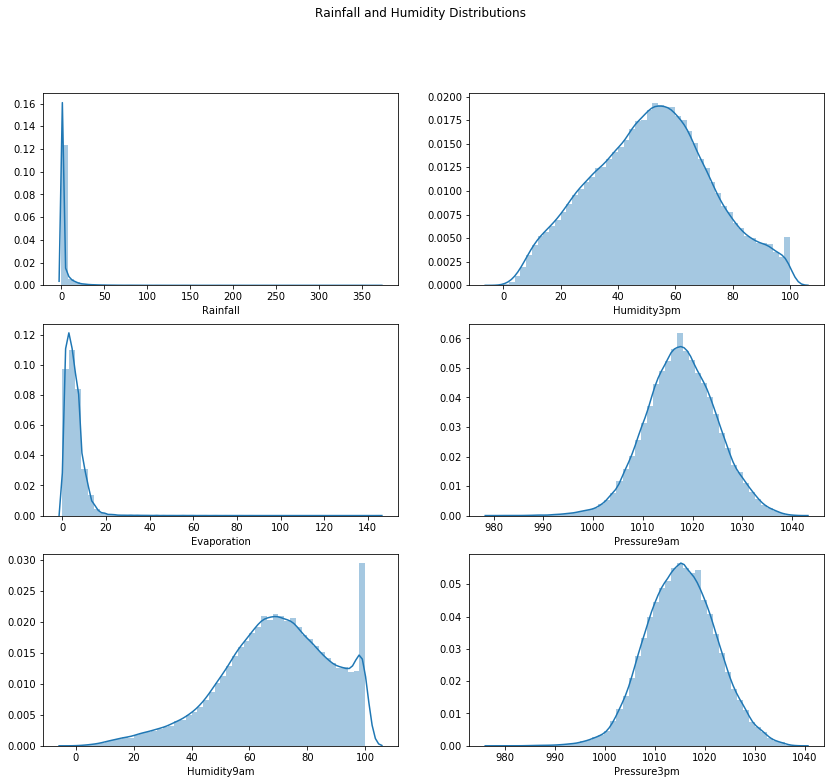

In [98]:
fig, axes = plt.subplots(3, 2, sharex = False, figsize = (14,12))
fig.suptitle("Rainfall and Humidity Distributions")
fig = sns.distplot(df_train['Rainfall'], ax = axes[0,0])
fig = sns.distplot(df_train['Evaporation'], ax = axes[1,0])
fig = sns.distplot(df_train['Humidity9am'], ax = axes[2,0])
fig = sns.distplot(df_train['Humidity3pm'], ax = axes[0,1])
fig = sns.distplot(df_train['Pressure9am'], ax = axes[1,1])
fig = sns.distplot(df_train['Pressure3pm'], ax = axes[2,1])
plt.show()

Pressure and humidity are nicely distributed with curves resembling a normal distribution. Humidity appears to max out at 100%, which leads to a spike at the highest value particularly in the 9am reading. Evaporation and Rainfall seem to be clustered in the 1 to 30 range, but there appears to be a long positive tail on both distributions. We can identify some of these unusually high readings as outliers in future sections to ensure the data is reliable.

### 2.2. Bivariate Analysis<a class="anchor" id = "2.2"></a>

Bivariate analysis involves examining relationships between the independent variables and the target(dependent variable). Features that appear to have strong correlations with the target can be selected at this stage to be used in the model.

### 2.3. Multivariate Analysis<a class="anchor" id = "2.3"></a>

For a large assessment of the features, we will run two plots: a pairplot to see any interactions between the variables, and a heatmap for a cleaner view of correlation coefficients. This step can help us identify coliniarities, and will help identify features to remove before training.

## 3. Feature Engineering<a class="anchor" id = "3"></a>

### 3.1. Numerical Feature Engineering: Missing Values and Outliers<a class="anchor" id = "3.1"></a>

Let's look at the missing data and see how well the features are recorded. If a feature has a high percentage of missing values, we have a few techniques available. We can:
    - Drop the feature column
    - Drop the rows with the missing feature's values (unwise)
    - Impute the feature, using the mean/median value (numerical) or the most common value (categorical).
    - Label these missing values as a separate category
The direction taken depends on whether the datapoints are missing completely at random, or if the missing data indicates some underlying pattern (e.g., missing wind speed might indicate a bad storm that causes the device to malfuntion). Imputation or dropping the rows can work if the missing data is randomly distributed, but it may skew the training data if there's an underlying cause.

In [24]:
# Numerical features
total = df_train[numerical].isnull().sum().sort_values(ascending=False)
percent = (df_train[numerical].isnull().sum()/df_train[numerical].isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Sunshine,48920,48.044627
Evaporation,43955,43.168470
Cloud3pm,41548,40.804541
Cloud9am,39133,38.432755
Pressure9am,10550,10.361219
Pressure3pm,10536,10.347469
WindGustSpeed,7145,7.017148
Humidity3pm,3179,3.122115
Temp3pm,2539,2.493567
Rainfall,2282,2.241166


### 3.2. Categorical Feature Engineering: Missing Values and One-hot enoding<a class="anchor" id = "3.2"></a>

In [23]:
## category missing values

total = df_train[categorical].isnull().sum().sort_values(ascending=False)
percent = (df_train[categorical].isnull().sum()/df_train[categorical].isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
WindDir9am,7396,7.263656
WindGustDir,7186,7.057414
WindDir3pm,2964,2.910962
RainToday,2282,2.241166
RainTomorrow,2269,2.228399
WeekNumber,0,0.000000
Weekday,0,0.000000
Location,0,0.000000


## 4. Model Training and Output<a class="anchor" id = "4"></a>

For the sake of this analysis, we will run the prepared data through a random forest model and determine how well it performs.

## 5. Model Performance Assessment<a class="anchor" id = "5"></a>

### 5.1. Accuracy vs Recall vs Specificity<a class="anchor" id = "5.1"></a>

As a basline for comparison, we can assess the model's accuracy compared to the '*null accuracy*'. The null accuracy is if the model only selects the majority class for all outcomes, which in this case is 'No' rain. This results in the following scores:

In [ ]:
## Null Accuracy
print("Training set null accuracy: "+ "\n")
print("Test set null accuracy: "+ "\n")

### 5.2. Confusion Matrix<a class="anchor" id = "5.2"></a>

### 5.3. ROC Curve and AUC<a class="anchor" id = "5.3."></a>

## 6. Enhancing the Dataset with Geocoding and topology data

In [ ]:
## 6.1. Geocoding the Locations<a class="anchor" id = "6.1"></a>

In [ ]:
## 6.2. Gathing topology features<a class="anchor" id = "6.2"></a>

In [ ]:
## 6.3. New Feature analysis<a class="anchor" id = "6.3"></a>

In [ ]:
## 6.4. New model training and output<a class="anchor" id = "6.4"></a>

In [ ]:
## 7. Conclusions and Future Directions<a class="anchor" id = "7"></a>

In [ ]:
smallW = trainSet[trainSet['Location'].isin(['Melbourne','Wollongong','Ballarat'])]



smallW['LogRainfall'] = np.log(smallW['Rainfall'])

feature_list = ['Location','LogRainfall','Sunshine','MaxTemp','Month','RainTomorrow']

plt.figure(figsize = (14,14 ) )
sns.pairplot(smallW[feature_list], hue = "RainTomorrow")
plt.show()

## Basic Modeling and Results
Now that we've taken a look at the core features, and placed some transformations to acheive normal distributions, we can run a decision tree-based classifier on the data to see how well these features predict for rain the next day.

We won't focus too much on tuning hyperparameters, or aggregating across models, as our goal is to identify external data that might improve the dataset with better features. Cross validation techniques are also an important step for ensureing the model doesn't overfit the training data.

## Providing context to locations
Despite the wealth of atmospheric data gathered from these stations, there is nothing in her that describes the physical location of these places. Our exploration reveals large differences in rainfall based on region, with the tropical stations collecting far more rain than the arid stations. While a basic mapping of location to State or 